# Trajectory Recommendation using BPR Ranking and Active Learning

## 1. Overview

1. BPR ranking of POIs
1. Recommend a set of POIs given (start, end, length)
1. Recommend POI visit duration
1. Recommend visiting order

In [1]:
% matplotlib inline

import os, re, sys, time, pickle
import math, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sop
from joblib import Parallel, delayed

In [2]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)

In [3]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [4]:
suffix = fvisit.split('-')[-1].split('.')[0]
fseqpart = os.path.join(data_dir, 'seqPart-' + suffix + '.pkl')

In [5]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID') # merge data frames according to column 'photoID'
#traj.head()

In [6]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


## 2.1 Compute POI Information

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [7]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [8]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [9]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.head()
#poi_all.to_csv(fpoi, index=True)

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
1,Sport,3506,-79.379243,43.643183
2,Sport,609,-79.418634,43.632772
3,Sport,688,-79.380045,43.662175
4,Sport,3056,-79.389290,43.641297
6,Cultural,986,-79.392396,43.653662


## 2.2 Construct Travelling Sequences

In [10]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,1,0
1,10012675@N05,2,6,1142731848,1142732445,4,597
2,10012675@N05,3,6,1142916492,1142916492,1,0
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257


In [11]:
seq_user = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_user.reset_index(inplace=True)
seq_user.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_user.set_index('seqID', inplace=True)
seq_user.head()

,userID,seqLen
seqID,,
1,10007579@N00,1
2,10012675@N05,1
3,10012675@N05,1
4,10012675@N05,1
5,10014440@N06,1


In [12]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort_values(by=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

## 2.3 Data Filtering 

Filtering out POI visits of which the duration is 0.

In [13]:
seq_all = seq_all[seq_all['poiDuration(sec)'] > 0]
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
1,10012675@N05,2,6,1142731848,1142732445,4,597
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257
5,10014440@N06,6,23,1198051767,1198052832,12,1065
6,10014440@N06,7,23,1198627025,1198627598,5,573


In [14]:
seq_stats = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_stats.reset_index(inplace=True)
seq_stats.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
seq_stats.head()

,userID,seqLen
seqID,,
2,10012675@N05,1
4,10012675@N05,1
5,10014440@N06,1
6,10014440@N06,1
7,10014440@N06,1


Filtering out sequences of which the length is less than 2.

In [15]:
seq_stats = seq_stats[seq_stats['seqLen'] > 2]
seq_stats.reset_index(inplace=True)
seq_stats.head()

,seqID,userID,seqLen
0,67,10502709@N05,3
1,100,10627620@N06,3
2,139,11090433@N05,4
3,166,11241023@N03,3
4,298,13644648@N03,7


In [16]:
seq_stats1 = seq_stats[['userID', 'seqID']].copy().groupby('userID').agg(np.size)
seq_stats1.rename(columns={'seqID':'#seq'}, inplace=True)

In [17]:
seq_stats1 = seq_stats1[seq_stats1['#seq'] >= 10]
seq_stats1.head()

,#seq
userID,
20741443@N00,13
84987970@N00,15


In [18]:
user_list = seq_stats1.index.tolist()
user_list.sort()
user_list

['20741443@N00', '84987970@N00']

In [19]:
seqid_list = seq_stats[seq_stats['userID'].isin(user_list)]['seqID'].tolist()
seqid_list.sort()
print(len(seqid_list))

28


## 2.4 Train vs. Query vs. Test Data

In [20]:
seq_exp_all = seq_all[seq_all['seqID'].isin(seqid_list)]
seq_exp_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
900,20741443@N00,708,7,1160213392,1160224452,4,11060
901,20741443@N00,708,21,1160215990,1160216293,3,303
902,20741443@N00,708,23,1160214708,1160215087,3,379
904,20741443@N00,708,30,1160222055,1160222178,2,123
910,20741443@N00,712,7,1170541310,1170548979,7,7669


In [21]:
seq_exp_all['seqID'].unique()

array([ 708,  712,  729,  783,  788,  807,  809,  825,  905,  920,  923,
        979,  980, 5180, 5183, 5207, 5214, 5250, 5254, 5263, 5276, 5277,
       5278, 5282, 5301, 5324, 5328, 5337])

In [22]:
poi_list = seq_exp_all['poiID'].unique().tolist()
poi_list.sort()
poi_list

[2, 3, 4, 6, 7, 11, 16, 17, 21, 22, 23, 24, 25, 27, 28, 29, 30]

In [23]:
user_seqid_all = dict()
for user in user_list:
    user_seqid_all[user] = seq_exp_all[seq_exp_all['userID'] == user]['seqID'].unique()

In [24]:
train_percent = 0.2
query_percent = 0.6

In [25]:
user_seqid_train = dict()
user_seqid_query = dict()
user_seqid_test  = dict()

In [26]:
for user in user_list:
    rand_idx = np.random.permutation(user_seqid_all[user].shape[0])
    ntrain = round(train_percent*user_seqid_all[user].shape[0])
    nquery = round(query_percent*user_seqid_all[user].shape[0])
    user_seqid_train[user] = user_seqid_all[user][:ntrain]
    user_seqid_query[user] = user_seqid_all[user][ntrain:ntrain+nquery]
    user_seqid_test[user]  = user_seqid_all[user][ntrain+nquery:]

In [27]:
for user in user_list:
    tmparray = np.sort(np.r_[user_seqid_train[user], user_seqid_query[user], user_seqid_test[user]])
    assert(np.all(tmparray == np.sort(user_seqid_all[user])))

## 2.5 Construct User-POI Visiting Matrix

$M_{ij}$ denotes the number of visits for user $u_i$ at POI $p_j$, $NaN$ for non-observed visits.

In [28]:
def calc_visit_df(user_list, poi_list, user_seqid_tuples):
    # return a DataFrame counting the #visit at each POI for specified users
    visit_df = pd.DataFrame(data=np.full((len(user_list), len(poi_list)), np.nan), columns=poi_list, index=user_list)
    for tuple_ in user_seqid_tuples:
        user = tuple_[0]
        seqid = tuple_[1]
        seq = extract_seq(seqid, seq_exp_all)
        for poi in seq:
            if np.isnan(visit_df.loc[user, poi]):
                visit_df.loc[user, poi] = 1
            else:
                visit_df.loc[user, poi] += 1
    return visit_df

In [29]:
user_seqid_tuples_all = [(user, seqid) for user in user_list for seqid in user_seqid_all[user]]
#user_seqid_tuples_all
visit_all_df = calc_visit_df(user_list, poi_list, user_seqid_tuples_all)

In [30]:
visit_all_df

,2,3,4,6,7,11,16,17,21,22,23,24,25,27,28,29,30
20741443@N00,NaN,NaN,NaN,NaN,11,1,NaN,NaN,6,6,7,1,NaN,NaN,3,NaN,6
84987970@N00,1,5,2,2,5,NaN,1,1,9,12,7,1,1,1,7,2,3


In [31]:
nan_mask = np.isnan(visit_all_df)
masked_visit = np.ma.masked_array(visit_all_df, nan_mask)

In [32]:
visits = pd.Series(masked_visit.flatten())

In [33]:
visits.describe()

count    24.000000
mean      4.208333
std       3.387691
min       1.000000
25%       1.000000
50%       3.000000
75%       6.250000
max      12.000000
dtype: float64

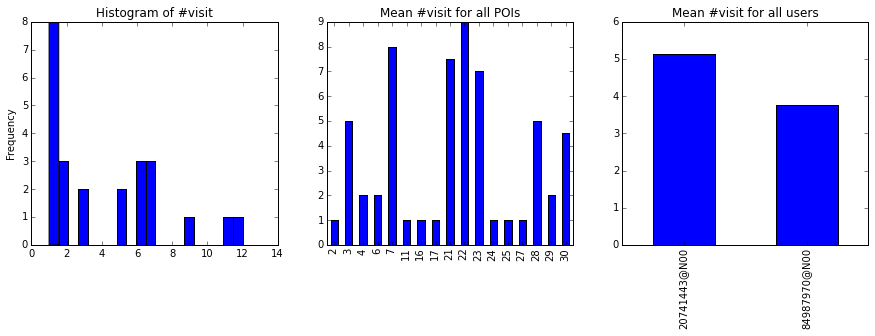

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

visits.plot(kind='hist', ax=ax1, bins=20, grid=False, title='Histogram of #visit')

poi_means = visit_all_df.mean(axis=0, skipna=True)
poi_means.plot(kind='bar', ax=ax2, grid=False, title='Mean #visit for all POIs')

user_means = visit_all_df.mean(axis=1, skipna=True)
user_means.plot(kind='bar', ax=ax3, grid=False, title='Mean #visit for all users')

In [35]:
user_seqid_tuples_train = [(user, seqid) for user in user_list for seqid in user_seqid_train[user]]
#user_seqid_tuples_train
visit_train_df0 = calc_visit_df(user_list, poi_list, user_seqid_tuples_train)

In [36]:
visit_train_df0

,2,3,4,6,7,11,16,17,21,22,23,24,25,27,28,29,30
20741443@N00,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,1,1,3,NaN,NaN,NaN,NaN,NaN,2
84987970@N00,1,1,1,NaN,NaN,NaN,NaN,1,2,2,1,NaN,1,NaN,NaN,NaN,NaN


In [37]:
nan_mask_train = np.isnan(visit_train_df0)
masked_visit_train = np.ma.masked_array(visit_train_df0, nan_mask_train)

In [38]:
visits_train = pd.Series(masked_visit_train.flatten())

In [39]:
visits_train.describe()

count    13.000000
mean      1.538462
std       0.776250
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       3.000000
dtype: float64

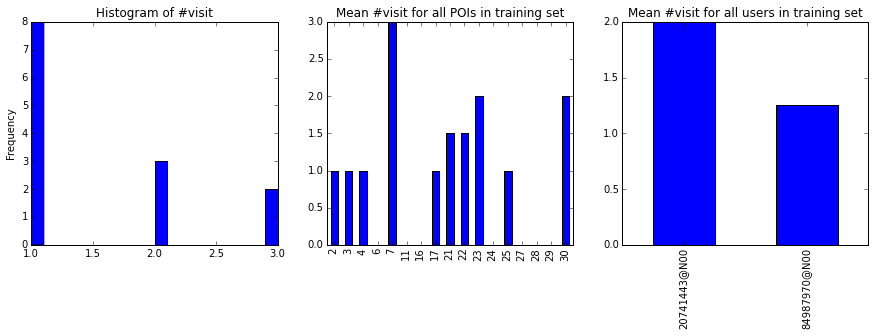

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

visits_train.plot(kind='hist', ax=ax1, bins=20, grid=False, title='Histogram of #visit')

poi_means_train = visit_train_df0.mean(axis=0, skipna=True)
poi_means_train.plot(kind='bar', ax=ax2, grid=False, title='Mean #visit for all POIs in training set')

user_means_train = visit_train_df0.mean(axis=1, skipna=True)
user_means_train.plot(kind='bar', ax=ax3, grid=False, title='Mean #visit for all users in training set')

## 2.6 Training using BPR

Compute index $(u, i, j)$ for user $u$ and visited POI $i$ and unvisited POI $j$.

In [41]:
def calc_x_ind(visit_train_df):
    # return array that stores tuple (u, i, j)
    # user u
    # POI i: u visited POI i
    # POI j: u didn't visit POI j
    
    # NaN indicator matrix
    nan_ind = np.isnan(visit_train_df)
    #print(nan_ind)
    
    # array that stores tuple (u, i, j)
    x_ind = []
    for u in np.arange(visit_train_df.shape[0]):
        #print(np.nonzero(nan_ind.iloc[u])[0])
        unvisited_ind = np.nonzero(nan_ind.iloc[u])[0]
        visited_ind = np.nonzero(~nan_ind.iloc[u])[0]
        tuples_u = [[u, i, j] for i in visited_ind for j in unvisited_ind]
        if len(x_ind) == 0:
            x_ind = tuples_u
        else:
            x_ind = np.r_[x_ind, tuples_u]
        
    return x_ind

Sanity check.

In [42]:
#x_ind0 = calc_x_ind(visit_train_df)

In [43]:
#print(x_ind0)

Objective function and gradient of (negative) BPR-OPT.

In [44]:
def obj_func(Theta, x_ind, nUser, Lambda):
    """
    :param Theta: ndarray, feature vectors/matrix of user and POI
    :param x_ind: ndarray, array contains tuple (u, i, j)
    :param nUser: int, number of users
    :param Lambda: float, regularization parameter
    :return negative of BPR-OPT, gradient of negative BPR-OPT w.r.t. parameters
    """
    
    # user features
    Theta_u = Theta[:nUser]
    
    # POI features
    Theta_p = Theta[nUser:]
    
    # user features w.r.t. index u
    f_u = Theta_u[x_ind[:, 0]]
    
    # POI features w.r.t. index i
    f_i = Theta_p[x_ind[:, 1]]
    
    # POI features w.r.t. index j
    f_j = Theta_p[x_ind[:, 2]]
    
    assert(f_u.shape == f_i.shape == f_j.shape)
    
    # \hat{x}_{ui} = dot_product(feature vector of user u, feature vector of POI i)
    x_ui = [np.dot(f_u[idx], f_i[idx]) for idx in np.arange(x_ind.shape[0])]
    #print(x_ui)
    
    # \hat{x}_{uj}
    x_uj = [np.dot(f_u[idx], f_j[idx]) for idx in np.arange(x_ind.shape[0])]
    #print(x_uj)
    
    # \hat{x}_{uij} = \hat{x}_{ui} - \hat{x}_{uj}
    x_uij = np.array(x_ui) - np.array(x_uj)
    #print(x_uij)
    
    # sum( ln( sigmoid(x_uij) ))
    obj = np.sum(np.log(1. / (1. + np.exp(-x_uij))))
    
    # regularization term
    #obj -= Lambda * np.multiply(Theta, Theta).sum() # causes math overflow when lambda=1
    
    # compute (negative) gradient of (negative) BPR-OPT w.r.t. model parameters
    # for SGD, just compute gradients given a random tuple (u, i, j) 
    grad_u = np.zeros_like(Theta_u, dtype=np.float)
    grad_p = np.zeros_like(Theta_p, dtype=np.float)   
    idx = np.random.choice(np.arange(x_ind.shape[0]))
    u, i, j = x_ind[idx]
    grad_u[u] = Theta_p[i] - Theta_p[j]
    grad_p[i] = Theta_u[u]
    grad_p[j] = -Theta_u[u]
    
    tmpval = math.exp(-x_uij[idx])
    grad = -tmpval / (1 + tmpval) * np.r_[grad_u, grad_p]
    #grad -= Lambda * Theta # regularization term # causes math overflow when lambda=1
    
    return obj, grad

In [45]:
def learn_BPR_SGD(visit_train_df, Theta0, Lambda, Alpha=1e-2, maxIter=1e6, ftol=1e-9):
    # learning procedure, maximize BPR-OPT w.r.t model parameters using stochastic gradient descent
    # return model parameters and objective history
    
    # number of users
    nUser = visit_train_df.shape[0]
    
    # index (u, i, j)
    x_ind = calc_x_ind(visit_train_df)
    
    Theta = Theta0.copy()
    
    nit = 0
    obj_prev = 0
    obj_history = []
    printstep = round(maxIter / 5, 2)
    
    while True:
        f, df = obj_func(Theta, x_ind, nUser, Lambda)
        if abs(obj_prev - f) < ftol or nit > maxIter:
            break
        obj_prev = f
        Theta -= Alpha * df
        obj_history.append(f)
        if nit % printstep == 0:
            print('Iteration %d, Objective: %.8f' % (nit, f)); sys.stdout.flush()
        nit += 1
            
    print('Iteration %d, Objective: %.8f' % (nit, obj_history[-1]))
    print('diff: %f' % np.abs(Theta - Theta0).sum())
    
    return Theta, obj_history
    
    #'Desired error not necessarily achieved due to precision loss.'
    #Theta = Theta0.reshape(np.prod(Theta0.shape)) # reshape to 1-dimension vector
    # minimize objective function using stochastic gradient descent (encoded in obj_func)
    # using scipy.minimize
    #result = sop.minimize(fun=obj_func, x0=Theta, args=(x_ind, nUser, Lambda), jac=True)
    #print(result)
    #if result.success:
        #return result.x.reshape(Theta0.shape)
    #else:
        #return None

In [46]:
# dimension for hidden features
# for each user: a DIM feature vector
# for each POI: a DIM feature vector
DIM = 10

# regularization constant
Lambda = 1e-5

# learning rate
Alpha = 0.01

# maximum number of iteration
maxIter = 1e5

# feature matrix
# for users: |U| x DIM
# for POIs: |POI| x DIM
Theta0 = np.random.rand(len(user_list) + len(poi_list), DIM)

In [47]:
Theta, history = learn_BPR_SGD(visit_train_df0, Theta0, Lambda, Alpha, maxIter)

Iteration 0, Objective: -109.87386597
Iteration 20000, Objective: -0.27287665
Iteration 40000, Objective: -0.11208064
Iteration 60000, Objective: -0.06833318
Iteration 80000, Objective: -0.04824043
Iteration 100000, Objective: -0.03697523
Iteration 100001, Objective: -0.03697523
diff: 70.988202


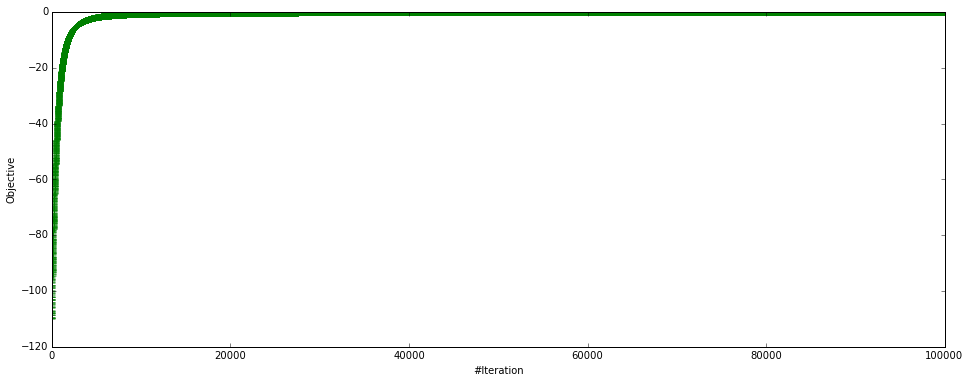

In [48]:
plt.figure(figsize=[16, 6])
plt.xlabel('#Iteration')
plt.ylabel('Objective')
plt.plot(np.arange(len(history)), history, ls='--', marker='+', color='g')

In [49]:
def calc_predicted_df(Theta, user_list, poi_list):
    nUser = len(user_list)
    Theta_u = Theta[:nUser] # user features
    Theta_p = Theta[nUser:] # POI features
    predicted_df = pd.DataFrame(data=np.zeros((nUser, len(poi_list)), dtype=np.float), columns=poi_list, index=user_list)
    for u in np.arange(len(user_list)):
        user = user_list[u]
        for p in np.arange(len(poi_list)):
            poi = poi_list[p]
            predicted_df.loc[user, poi] = np.dot(Theta_u[u], Theta_p[p])
    return predicted_df

In [50]:
def calc_compare_df(visited_df, predicted_df, scale_factor=1):
    userlist_ = predicted_df.index.tolist()
    poilist_ = predicted_df.columns.tolist()
    compare_df = pd.DataFrame(data=np.zeros((len(poilist_), 2*len(userlist_)), dtype=np.float), index=poilist_)
    for u in range(len(userlist_)):
        user = userlist_[u]
        compare_df.iloc[:, 2*u] = visited_df.loc[user]
        compare_df.iloc[:, 2*u+1] = np.round(predicted_df.loc[user]*scale_factor, 1)
        compare_df.rename(columns=\
                          {compare_df.columns[2*u]:'REAL_' + str(user), compare_df.columns[2*u+1]:'PRED_' + str(user)}, \
                          inplace=True)
    return compare_df

In [51]:
predicted_df0 = calc_predicted_df(Theta, user_list, poi_list)
predicted_df0

,2,3,4,6,7,11,16,17,21,22,23,24,25,27,28,29,30
20741443@N00,2.552960,2.195888,2.174276,2.417906,10.010544,1.945830,0.674738,2.484097,10.446289,10.353489,10.257024,1.36027,2.402403,1.844503,2.062746,1.858002,10.092226
84987970@N00,8.685891,9.069142,8.988505,-0.652646,1.191739,0.269904,1.072170,9.007430,8.957274,9.409995,9.472484,0.86236,8.805264,0.627963,0.658094,0.801226,1.164977


In [52]:
compare_df = calc_compare_df(visit_all_df, predicted_df0)
compare_df

,REAL_20741443@N00,PRED_20741443@N00,REAL_84987970@N00,PRED_84987970@N00
2,NaN,2.6,1,8.7
3,NaN,2.2,5,9.1
4,NaN,2.2,2,9.0
6,NaN,2.4,2,-0.7
7,11,10.0,5,1.2
11,1,1.9,NaN,0.3
16,NaN,0.7,1,1.1
17,NaN,2.5,1,9.0
21,6,10.4,9,9.0
22,6,10.4,12,9.4


In [53]:
def calc_order_error(visited_df, predicted_df):
    error_rates = dict()
    nan_ind = np.isnan(visited_df) # NaN indicator matrix
    for u in range(visited_df.shape[0]):
        unvisited_ind = np.nonzero(nan_ind.iloc[u])[0]
        visited_ind = np.nonzero(~nan_ind.iloc[u])[0]
        total = len(visited_ind) * len(unvisited_ind)
        error = 0
        for idx in unvisited_ind:
            #print(predicted_df.iloc[u, idx])
            #print(predicted_df.iloc[u, visited_ind].values)
            error += np.sum(predicted_df.iloc[u, idx] > predicted_df.iloc[u, visited_ind].values)
        #error_rates[predicted_df.index[u]] = [error / total, error, total]
        error_rates[predicted_df.index[u]] = error / total
    return error_rates

In [54]:
calc_order_error(visit_all_df, predicted_df0)

{'20741443@N00': 0.27777777777777779, '84987970@N00': 0.0625}

In [55]:
train_error_rates0 = calc_order_error(visit_train_df0, predicted_df0)
train_error_rates0

{'20741443@N00': 0.0, '84987970@N00': 0.0}

In [56]:
user_seqid_tuples_test = [(user, seqid) for user in user_list for seqid in user_seqid_test[user]]
visit_test_df0 = calc_visit_df(user_list, poi_list, user_seqid_tuples_test)

In [57]:
test_error_rates0 = calc_order_error(visit_test_df0, predicted_df0)
test_error_rates0

{'20741443@N00': 0.38333333333333336, '84987970@N00': 0.18333333333333332}

## 2.7 Random Baseline

Random baseline, i.e. passive learning.

In [58]:
def calc_F1score(poi_set_act, poi_set_rec):
    assert(len(poi_set_act) > 0)
    assert(len(poi_set_rec) > 0)
    actset = set(poi_set_act)
    recset = set(poi_set_rec)
    intersect = actset & recset
    recall = len(intersect) / len(poi_set_act)
    precision = len(intersect) / len(poi_set_rec)
    F1score = 2. * precision * recall / (precision + recall)
    return F1score

In [59]:
def evaluate(Theta, user_list, poi_list, user_seqid_tuples_test):
    predicted_df = calc_predicted_df(Theta, user_list, poi_list)
    F1scores = []
    for user, seqid in user_seqid_tuples_test:
        poi_set_act = extract_seq(seqid, seq_exp_all)
        p_idx = predicted_df.loc[user].argsort()
        decreased = predicted_df.columns[p_idx.values][::-1]
        poi_set_rec = [p for p in decreased if p not in {poi_set_act[0], poi_set_act[-1]}][:len(poi_set_act)-2]
        poi_set_rec.extend([poi_set_act[0], poi_set_act[-1]])
        F1 = calc_F1score(poi_set_act, poi_set_rec)
        F1scores.append(F1)
    return F1scores

In [60]:
user_seqid_tuples_train = [(user, seqid) for user in user_list for seqid in user_seqid_train[user]]
visit_train_df = calc_visit_df(user_list, poi_list, user_seqid_tuples_train)

In [61]:
errors_train = [np.mean(list(train_error_rates0.values()))]
errors_train

[0.0]

In [62]:
visit_test_df = visit_test_df0.copy()
errors_test =  [np.mean(list(test_error_rates0.values()))]

In [63]:
user_seqid_tuples_query = [(user, seqid) for user in user_list for seqid in user_seqid_query[user]]
#user_seqid_tuples_query

In [64]:
user_seqid_tuples_test = [(user, seqid) for user in user_list for seqid in user_seqid_test[user]]

In [65]:
F1scores_test = []
tuples_idx = np.arange(len(user_seqid_tuples_query))
np.random.shuffle(tuples_idx)
for idx in tuples_idx:
    user = user_seqid_tuples_query[idx][0]
    seqid = user_seqid_tuples_query[idx][1]
    seq = extract_seq(seqid, seq_exp_all)
    print('choose: (%s, %s)' % (user, seq))
    for poi in seq:
        if np.isnan(visit_train_df.loc[user, poi]): 
            visit_train_df.loc[user, poi] = 1
        else:
            visit_train_df.loc[user, poi] += 1
    Theta0 = np.random.rand(len(user_list) + len(poi_list), DIM)
    Theta, history = learn_BPR_SGD(visit_train_df, Theta0, Lambda, Alpha, maxIter)
    
    F1scores = evaluate(Theta, user_list, poi_list, user_seqid_tuples_test)
    F1scores_test.append(F1scores)
    print('F1: (%.2f, %2.f)' % (np.mean(F1scores), np.std(F1scores)))
    
    predicted_df = calc_predicted_df(Theta, user_list, poi_list)
    
    err_train = np.mean(list(calc_order_error(visit_train_df, predicted_df).values()))
    err_test = np.mean(list(calc_order_error(visit_test_df, predicted_df).values()))
    errors_train.append(err_train)
    errors_test.append(err_test)
    print('mean error: %.2f, %.2f' % (err_train, err_test))

choose: (20741443@N00, [21, 11, 22])
Iteration 0, Objective: -76.96142895
Iteration 20000, Objective: -0.28028165
Iteration 40000, Objective: -0.11773956
Iteration 60000, Objective: -0.07203326
Iteration 80000, Objective: -0.05115036
Iteration 100000, Objective: -0.03929951
Iteration 100001, Objective: -0.03929951
diff: 67.403146
F1: (0.75,  0)
mean error: 0.00, 0.26
choose: (20741443@N00, [30, 7, 21])
Iteration 0, Objective: -108.80190090
Iteration 20000, Objective: -0.28818901
Iteration 40000, Objective: -0.11883760
Iteration 60000, Objective: -0.07253172
Iteration 80000, Objective: -0.05133719
Iteration 100000, Objective: -0.03941696
Iteration 100001, Objective: -0.03941696
diff: 74.071189
F1: (0.82,  0)
mean error: 0.00, 0.26
choose: (20741443@N00, [23, 22, 28])
Iteration 0, Objective: -98.95764185
Iteration 20000, Objective: -0.29492069
Iteration 40000, Objective: -0.12232773
Iteration 60000, Objective: -0.07475749
Iteration 80000, Objective: -0.05301833
Iteration 100000, Objectiv

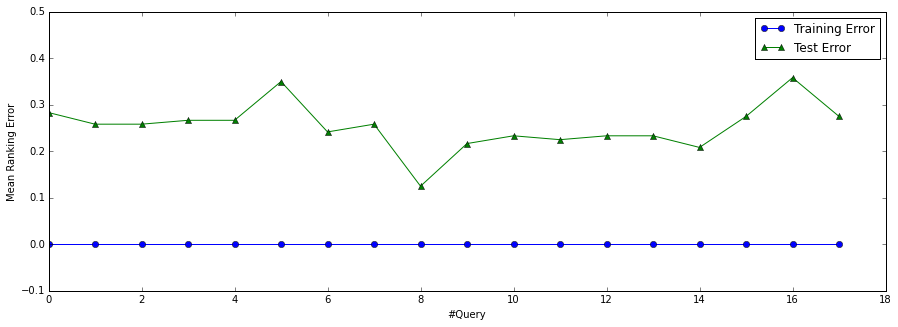

In [66]:
plt.figure(figsize=[15, 5])
plt.xlabel('#Query')
plt.ylabel('Mean Ranking Error')
plt.ylim([-0.1, 0.5])
plt.plot(np.arange(len(errors_train)), errors_train, label='Training Error', marker='o')
plt.plot(np.arange(len(errors_test)), errors_test, label='Test Error', marker='^')
plt.legend(loc='upper right')

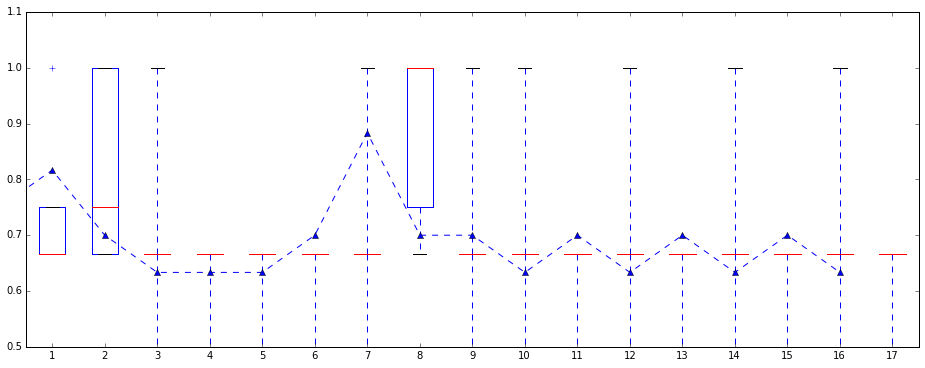

In [67]:
plt.figure(figsize=[16, 6])
plt.boxplot(F1scores_test)
plt.plot(np.arange(len(F1scores_test)), [np.mean(x) for x in F1scores_test], marker='^', ls='--')